In [1]:
import os
path_kaggle=os.path.join('w:\\','Documents','kaggle','cats_vs_dogs')
print(path_kaggle)

w:\Documents\kaggle\cats_vs_dogs


In [55]:
from random import shuffle
from collections import defaultdict
import shutil
import pathlib

def load_train_data(path_dest,data_split_type,limit_per_class):
    return_dict={d:defaultdict(list) for d in data_split_type}
    is_already_there=False
    for d in data_split_type:
        if not os.path.exists(os.path.join(path_dest,d)):
            is_already_there=False
            return
        
        if len(os.listdir(os.path.join(path_dest,d)))>0:
            is_already_there=True
            print('Files aready copied to',os.path.join(path_dest,d))
            for root, subdirs, files_indir in os.walk(os.path.join(path_dest,d)):
                if not subdirs:
                    path = os.path.normpath(root)
                    file_class=path.split(os.sep)[-1]
                    shuffle(files_indir)
                    for file_name in files_indir:
                        file_name_as_list=file_name.split('.')
                        if len(file_name_as_list)==3:
                            return_dict[d][file_class].extend([os.path.join(path_dest,d,file_class,file_name)])

    for k_type,k_type_dict in return_dict.items():
        for k,v in k_type_dict.items():
            print('Loaded previously selected',k_type,k,'files -> ',len(v))
            assert limit_per_class[k_type]==len(v)

    return return_dict if is_already_there else None

def split_train_data(path_in,path_out,limit_per_class):    
    path_source=os.path.join(path_kaggle,path_in)
    path_dest=os.path.join(path_kaggle,path_out)
    data_split_type=['train','test','validate']
    return_dict={d:defaultdict(list) for d in data_split_type}

    load_train_data_result=load_train_data(path_dest,data_split_type,limit_per_class)    
    if load_train_data_result:
        return load_train_data_result
    
    files=[]
    for root, subdirs, files_indir in os.walk(path_source):
        print('root = ' , root," files=",len(os.listdir(root)))
        for file in files_indir:
            if pathlib.Path(os.path.join(root,file)).suffix.lower()=='.jpg':
                files.extend([os.path.join(root,file)])
    
    shuffle(files)
    for file_index, file_name in enumerate(files):
        file_name_as_list=os.path.basename(file_name).split('.')
        if len(file_name_as_list)==3:
            file_class=file_name_as_list[0]
            isUsed=False
            for d in data_split_type:                    
                if len(return_dict[d][file_class])<limit_per_class[d] and not isUsed:
                    return_dict[d][file_class].extend([os.path.join(root,file_name)])
                    isUsed=True
                else:continue
    
    for k_type,k_type_dict in return_dict.items():
        for k,v in k_type_dict.items():
            print('Copying',len(v),'randomly',k,'selected','files','to',os.path.join(path_dest,k_type,k))
            os.makedirs(os.path.join(path_dest,k_type,k), exist_ok=True)
            for file in v:
                shutil.copy(file,os.path.join(path_dest,k_type,k,os.path.basename(file)))
    return return_dict

# result=split_train_data(os.path.join('original','train'),'solution',limit_per_class={'train':5625,'test':6250,'validate':625});
result=split_train_data(os.path.join('original','train'),'solution',
                        limit_per_class={'train':1000,'test':500,'validate':500,'classes':2});
# result=split_train_data(os.path.join('original','train'),'solution',limit_per_class={'train':10,'test':5,'validate':5});

# result=split_train_data('original','solution',limit_per_class={'train':10,'test':5,'validate':5})


Files aready copied to w:\Documents\kaggle\cats_vs_dogs\solution\train
Files aready copied to w:\Documents\kaggle\cats_vs_dogs\solution\test
Files aready copied to w:\Documents\kaggle\cats_vs_dogs\solution\validate
Loaded previously selected train cat files ->  1000
Loaded previously selected train dog files ->  1000
Loaded previously selected test cat files ->  500
Loaded previously selected test dog files ->  500
Loaded previously selected validate cat files ->  500
Loaded previously selected validate dog files ->  500


In [6]:
from keras.preprocessing.image import ImageDataGenerator
def load_train_data_combine(classes_dict):
    pass

train_datagen = ImageDataGenerator(rescale=1./255)
validate_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(directory=os.path.join(path_kaggle,'solution','train')
                                        ,target_size=(150, 150)
                                        ,batch_size=20
                                        ,class_mode='binary')

validate_generator=validate_datagen.flow_from_directory(directory=os.path.join(path_kaggle,'solution','validate')
                                        ,target_size=(150, 150)
                                        ,batch_size=20
                                        ,class_mode='binary')

w:\dev\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

from keras import optimizers
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
            metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [8]:
#Time per epoch: CPU=2 minutes, GPU=8 seconds
history = model.fit_generator(
                            train_generator,
                            steps_per_epoch=100,
                            epochs=10,
                            validation_data=validate_generator,
                            validation_steps=50)

Epoch 1/10
100/100 [==============================] - 20s 201ms/step - loss: 0.6885 - acc: 0.5350 - val_loss: 0.6923 - val_acc: 0.5030
Epoch 2/10
100/100 [==============================] - 8s 80ms/step - loss: 0.6612 - acc: 0.6000 - val_loss: 0.6828 - val_acc: 0.5470
Epoch 3/10
100/100 [==============================] - 8s 80ms/step - loss: 0.6268 - acc: 0.6490 - val_loss: 0.6246 - val_acc: 0.6290
Epoch 4/10
100/100 [==============================] - 8s 80ms/step - loss: 0.5906 - acc: 0.6770 - val_loss: 0.6492 - val_acc: 0.6310
Epoch 5/10
100/100 [==============================] - 8s 80ms/step - loss: 0.5653 - acc: 0.7085 - val_loss: 0.5853 - val_acc: 0.6970
Epoch 6/10
100/100 [==============================] - 8s 80ms/step - loss: 0.5256 - acc: 0.7410 - val_loss: 0.5674 - val_acc: 0.6880
Epoch 7/10
100/100 [==============================] - 8s 80ms/step - loss: 0.4979 - acc: 0.7600 - val_loss: 0.5735 - val_acc: 0.6900
Epoch 8/10
100/100 [==============================] - 8s 80ms/step 

In [24]:
model.save('cats_and_dogs_small_1.h5')

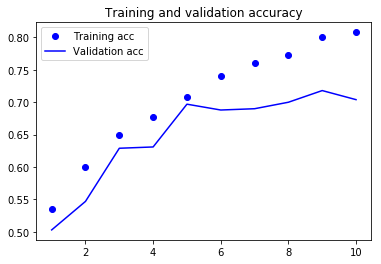

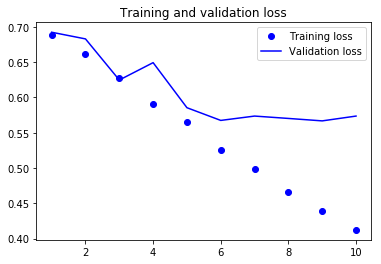

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_train_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
plot_train_history(history)

# Image Augmentation
#### Displaying some randomly augmented training images

In [90]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

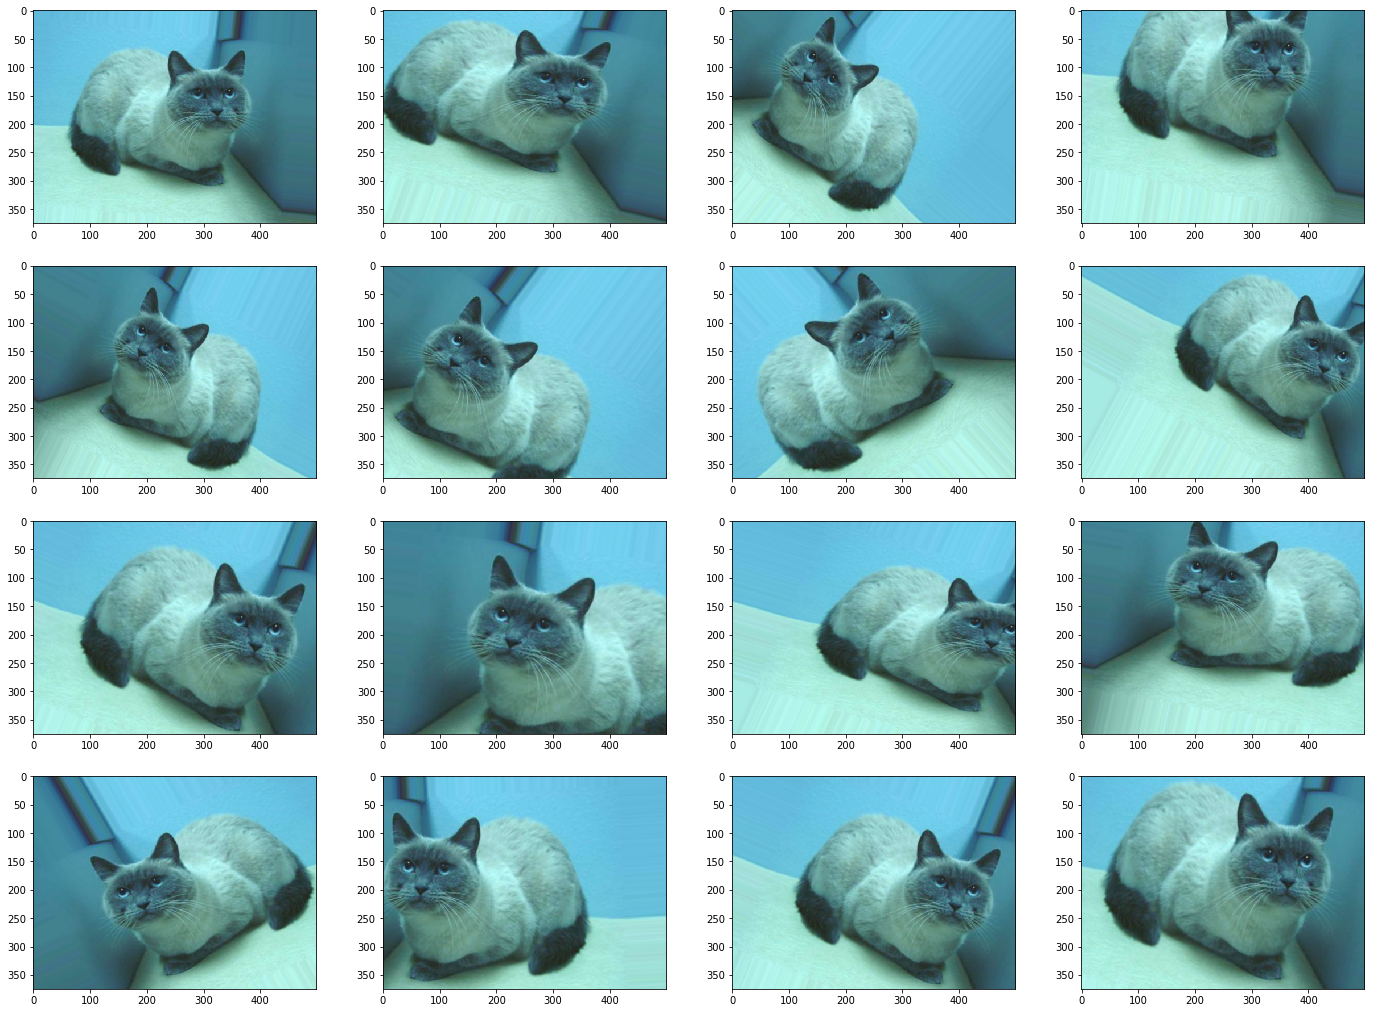

In [93]:
from keras.preprocessing import image
import math

img=image.load_img(result['train']['cat'][1])
img=image.img_to_array(img)
img=img.reshape((1,)+img.shape)

dpi_multiplier=2
fig = plt.figure(figsize=(12*dpi_multiplier,9*dpi_multiplier))
how_many=16
for (i,batch) in enumerate(datagen.flow(img,batch_size=1)):
    fig.add_subplot(math.ceil(math.sqrt(how_many)),math.ceil(math.sqrt(how_many)),i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    if i==how_many-1:break

plt.show()